## Coded by Connor Crawford

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":]
yen_futures = yen_futures.drop(columns = 'Change')
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest
Date,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'] = ((yen_futures['Settle'].pct_change())*100)
yen_futures.dropna(inplace = True)
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,
1990-01-03,6877.0,6910.0,6865.0,6887.0,6887.0,38206.0,53860.0,0.584197
1990-01-04,6937.0,7030.0,6924.0,7008.0,7008.0,49649.0,55699.0,1.756933
1990-01-05,6952.0,6985.0,6942.0,6950.0,6950.0,29944.0,53111.0,-0.827626
1990-01-08,6936.0,6972.0,6936.0,6959.0,6959.0,19763.0,52072.0,0.129496
1990-01-09,6918.0,6927.0,6892.0,6915.0,6915.0,29784.0,52111.0,-0.632275


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures['Return'].shift()
yen_futures.dropna(inplace = True)
yen_futures.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,
1990-01-04,6937.0,7030.0,6924.0,7008.0,7008.0,49649.0,55699.0,1.756933,0.584197
1990-01-05,6952.0,6985.0,6942.0,6950.0,6950.0,29944.0,53111.0,-0.827626,1.756933
1990-01-08,6936.0,6972.0,6936.0,6959.0,6959.0,19763.0,52072.0,0.129496,-0.827626
1990-01-09,6918.0,6927.0,6892.0,6915.0,6915.0,29784.0,52111.0,-0.632275,0.129496
1990-01-10,6905.0,6940.0,6885.0,6887.0,6887.0,34290.0,54735.0,-0.404917,-0.632275


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]
train.head()

,Open,High,Low,Last,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,
1990-01-04,6937.0,7030.0,6924.0,7008.0,7008.0,49649.0,55699.0,1.756933,0.584197
1990-01-05,6952.0,6985.0,6942.0,6950.0,6950.0,29944.0,53111.0,-0.827626,1.756933
1990-01-08,6936.0,6972.0,6936.0,6959.0,6959.0,19763.0,52072.0,0.129496,-0.827626
1990-01-09,6918.0,6927.0,6892.0,6915.0,6915.0,29784.0,52111.0,-0.632275,0.129496
1990-01-10,6905.0,6940.0,6885.0,6887.0,6887.0,34290.0,54735.0,-0.404917,-0.632275


In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Return'].to_frame()
X_test = test['Lagged_Return'].to_frame()
y_train = train['Return']
y_test = test['Return']

In [8]:
y_train

Date
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
1990-01-10   -0.404917
                ...   
2017-12-22    0.118370
2017-12-26    0.118230
2017-12-27   -0.151830
2017-12-28    0.180221
2017-12-29    0.224871
Name: Return, Length: 7062, dtype: float64

# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)
predictions.shape

(451,)

In [12]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['Predicted Return'] = predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA5D811C10>,
      dtype=object)

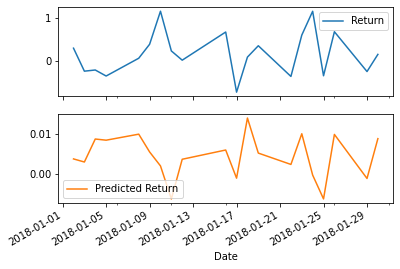

In [13]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots = True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [14]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
oos_mse = mean_squared_error(results['Return'], results['Predicted Return'])
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
oos_rmse = np.sqrt(oos_mse)
print('Out-of-Sample Root Mean Squared Error (RMSE): ' + str(oos_rmse))

Out-of-Sample Root Mean Squared Error (RMSE): 0.4136504970669482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [18]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results['Predictions'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
is_mse = mean_squared_error(in_sample_results['Return'], in_sample_results['Predictions'])
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
is_rmse = np.sqrt(is_mse)

print('In-sample Root Mean Squared Error (RMSE):' + str(is_rmse))

In-sample Root Mean Squared Error (RMSE):0.7059387714146014


# Conclusions

YOUR CONCLUSIONS HERE!

## Based exclusively on the root mean squared error, it would appear that this model works better on out of sample data with an rmse of 0.414 than in sample data with an rmse of 0.706. However, there is MUCH more in sample data, seeing as those dates range from 1990 to 2018, whereas the test dates only range from 2018 to 2019, so I could see that impacting the error.